word2vecの学習済みモデルを使う
- https://gist.github.com/wai-doi/f0c85d64253b35746e3ca5fb327e10b8
- https://qiita.com/Hironsan/items/513b9f93752ecee9e670

In [1]:
import gensim
# 読み込みに3分くらいかかる
target = gensim.models.KeyedVectors.load_word2vec_format('model/model.vec', binary=False)

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from word import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

In [3]:
with open("dict/saimeno-v4-simp.json") as f:
    words = json.load(f)

# 音素列 → 単語ベクトル
# vecs = {k : target[words[k][0]].tolist() for k in words}
vecs = {k : np.mean([target[t] for t in words[k]], axis=0).tolist() for k in words} # 平均をとってみる

with open("dict/saimeno-v4-simp-vec.json", "w") as f:
    json.dump(vecs, f, ensure_ascii=False, indent=2)

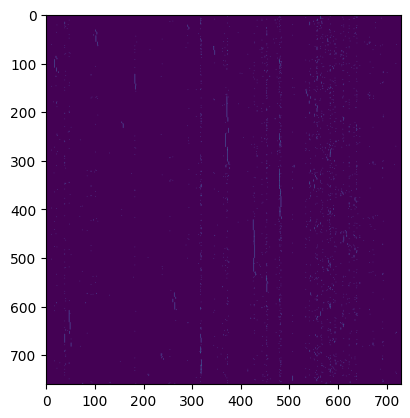

In [71]:
P = [Word(x).ph for x in vecs]
V = np.array(list(vecs.values()))

# bigramに分解
X = std_sys.ph["X"]
X2 = prod(X, X)
invX2 = lambda x : X2.index(x)

E = np.eye(len(X2))
to_input = lambda w : np.sum([E[invX2([w[i],w[i+1]])] for i in range(len(w)-1)], axis=0)
P = np.array([to_input(w) for w in P])
# P /= np.sum(P, axis=1, keepdims=True) # 正規化しなくてもいい(?)
plt.imshow(P)

順方向(音素列 → 意味)の学習

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = len(X2)
hidden_size1 = 500
hidden_size2 = 500
output_size = len(target[0])

model = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)

print(model)

SimpleNN(
  (fc1): Linear(in_features=729, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=300, bias=True)
)


In [51]:
X_train = torch.tensor(P, dtype=torch.float32)
y_train = torch.tensor(V, dtype=torch.float32)

dataset = TensorDataset(X_train, y_train)

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')



Epoch [1/40], Loss: 0.0517
Epoch [2/40], Loss: 0.0485
Epoch [3/40], Loss: 0.0458
Epoch [4/40], Loss: 0.0427
Epoch [5/40], Loss: 0.0396
Epoch [6/40], Loss: 0.0370
Epoch [7/40], Loss: 0.0346
Epoch [8/40], Loss: 0.0323
Epoch [9/40], Loss: 0.0302
Epoch [10/40], Loss: 0.0284
Epoch [11/40], Loss: 0.0266
Epoch [12/40], Loss: 0.0249
Epoch [13/40], Loss: 0.0234
Epoch [14/40], Loss: 0.0220
Epoch [15/40], Loss: 0.0207
Epoch [16/40], Loss: 0.0195
Epoch [17/40], Loss: 0.0184
Epoch [18/40], Loss: 0.0173
Epoch [19/40], Loss: 0.0163
Epoch [20/40], Loss: 0.0154
Epoch [21/40], Loss: 0.0146
Epoch [22/40], Loss: 0.0138
Epoch [23/40], Loss: 0.0131
Epoch [24/40], Loss: 0.0124
Epoch [25/40], Loss: 0.0118
Epoch [26/40], Loss: 0.0112
Epoch [27/40], Loss: 0.0107
Epoch [28/40], Loss: 0.0101
Epoch [29/40], Loss: 0.0097
Epoch [30/40], Loss: 0.0092
Epoch [31/40], Loss: 0.0089
Epoch [32/40], Loss: 0.0085
Epoch [33/40], Loss: 0.0081
Epoch [34/40], Loss: 0.0078
Epoch [35/40], Loss: 0.0075
Epoch [36/40], Loss: 0.0072
E

In [52]:
samples = ["moftalto", "mistakk", "stande", "tceskopt", "kwaflaim", "alkono", "kotokay", "kanon", "folzce", "skinoa"]

ans = {}
model.eval()
with torch.no_grad():
    for w in samples:
        input = torch.tensor(to_input(w), dtype=torch.float32)
        prediction = model(input).numpy()
        tmp = target.similar_by_vector(prediction, topn=50)[::3]
        ans[w] = [t[0] for t in tmp]

with open("generated/samples.json", "w") as f:
    json.dump(ans, f, ensure_ascii=False, indent=2)

In [53]:
with open("generated/markov01.txt") as f:
    words = f.read().split("\n")

ans = {}
with torch.no_grad():
    for w in tqdm(words):
        input = torch.tensor(to_input(w), dtype=torch.float32)
        prediction = model(input).numpy()
        d = 5
        n = 10
        tmp = target.similar_by_vector(prediction, topn=n*d)[::d]
        ans[w] = [t[0] for t in tmp]

with open("generated/predictions01.json", "w") as f:
    json.dump(ans, f, ensure_ascii=False, indent=2)

100%|██████████| 321/321 [00:21<00:00, 14.78it/s]


逆方向(意味 → 音素列)の学習

In [115]:
# モデル定義
class SimpleRevNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleRevNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # BCEWithLogitsLossは内部でsigmoidを適用
        return x

# モデルとデータ準備
input_size = len(target[0])
hidden_size1 = 500
hidden_size2 = 500
output_size = len(X2)

model = SimpleRevNN(input_size, hidden_size1, hidden_size2, output_size)
print(model)

SimpleRevNN(
  (fc1): Linear(in_features=300, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=729, bias=True)
)


In [137]:
# 入力データとターゲットの準備
X_train = torch.tensor(V, dtype=torch.float32)
P_normalized = P / P.max(axis=1, keepdims=True)  # ターゲットの正規化（必要に応じて）
y_train = torch.tensor(P_normalized, dtype=torch.float32)

dataset = TensorDataset(X_train, y_train)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 損失関数とオプティマイザ
criterion = nn.BCEWithLogitsLoss()  # 多ラベル分類向け
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデル学習
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)  # Sigmoidは不要
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

Epoch [1/40], Loss: 0.0034
Epoch [2/40], Loss: 0.0028
Epoch [3/40], Loss: 0.0027
Epoch [4/40], Loss: 0.0026
Epoch [5/40], Loss: 0.0024
Epoch [6/40], Loss: 0.0022
Epoch [7/40], Loss: 0.0022
Epoch [8/40], Loss: 0.0021
Epoch [9/40], Loss: 0.0021
Epoch [10/40], Loss: 0.0021
Epoch [11/40], Loss: 0.0020
Epoch [12/40], Loss: 0.0019
Epoch [13/40], Loss: 0.0019
Epoch [14/40], Loss: 0.0018
Epoch [15/40], Loss: 0.0018
Epoch [16/40], Loss: 0.0018
Epoch [17/40], Loss: 0.0017
Epoch [18/40], Loss: 0.0017
Epoch [19/40], Loss: 0.0017
Epoch [20/40], Loss: 0.0017
Epoch [21/40], Loss: 0.0017
Epoch [22/40], Loss: 0.0016
Epoch [23/40], Loss: 0.0016
Epoch [24/40], Loss: 0.0018
Epoch [25/40], Loss: 0.0016
Epoch [26/40], Loss: 0.0016
Epoch [27/40], Loss: 0.0016
Epoch [28/40], Loss: 0.0015
Epoch [29/40], Loss: 0.0016
Epoch [30/40], Loss: 0.0015
Epoch [31/40], Loss: 0.0015
Epoch [32/40], Loss: 0.0016
Epoch [33/40], Loss: 0.0015
Epoch [34/40], Loss: 0.0015
Epoch [35/40], Loss: 0.0015
Epoch [36/40], Loss: 0.0014
E

In [ ]:
samples = ["学生", "家", "きのこ"]
# samples = [target[w] for w in samples]

ans = {}
model.eval()
with torch.no_grad():
    for w in samples:
        print(w)
        w = target[w]
        input = torch.tensor(w, dtype=torch.float32)
        prediction = torch.sigmoid(model(input)).numpy()
        # prediction = model(input).numpy()
        # prediction = np.where(prediction >= 0, prediction, 1e-10)
        # print(prediction)
        indices = np.where(prediction >= 0.001)[0]
        indices = indices[np.argsort(prediction[indices])[::-1]]
        bigrams = ["".join(X2[i]) for i in indices]
        print(bigrams)
        # 遷移行列
        Prob = np.zeros((len(X), len(X)))
        # print(np.sum(prediction))
        for k, p in enumerate(prediction):
            L = len(X)
            Prob[k//L][k%L] += p # +=にしたけど一回しか代入されないので=でもいいはず
        Prob /= np.sum(Prob, axis=1, keepdims=True)
        # 適当マルコフ連鎖
        res_set = set()
        for _ in range(10):
            p = np.ones(len(X)) / len(X)
            res = ""
            length = int(np.random.normal(8, 2))
            for _ in range(length):
                p = np.dot(p, Prob)
                # print(p)
                i = np.random.choice(np.arange(len(X)), p=p)
                res += X[i]
                p = np.eye(len(X))[i]
            w = Word(res)
            if not w.is_valid:
                continue
            res_set.add(res)
        print(res_set)
        

学生
['st', 'ku', 'is', 'na', 'ui', 'ac', 'tn', 'oy', 'on', 'en', 'to', 'ok', 'mo']
{'oystnaca', 'istnacu', 'ona', 'aconacona', 'istnacaco', 'cacoy'}
家
['to', 'aa', 'at', 'kha', 'ov', 'ot', 'ta', 'la', 'pt', 'cc', 'ic', 'af']
{'ovla', 'atovlaa', 'latovlaatov', 'glaatovl', 'latovla'}
